In [1]:
#NLP project - classement de texte selon toxicité.

#le but de ce premier projet NLP est de se familiariser avec les bases du Traitement automatique
#du langage naturel et de l'analyse de sentiment
#je vais réutiliser les techniques de l'exercise kaggle et des tweets de Trump
#la prédiction se fera en entrainant un classifieur, plusieurs si le premier ne donne pas satisfaction

#cela nous servira de base pour le prochain projet, qui sera plus complexe

In [2]:
#import des librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os

import gensim
import nltk
import sklearn

import re
import string
from string import digits

In [3]:
#chargement des données

toxic_train = pd.read_csv('toxic_comment_classification_train.csv')
toxic_test = pd.read_csv('toxic_comment_classification_test.csv')

In [4]:
#analyse du jeu train
toxic_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
toxic_train.shape

(159571, 8)

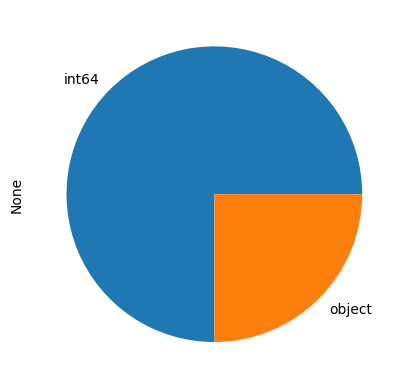

In [6]:
#types de variables
##pourcentage de valeurs en fonction de chaque type d'objets et de valeurs manquantes
toxic_train.dtypes.value_counts().plot.pie();

In [7]:
#nombre et type des variables

toxic_train.dtypes.value_counts()

int64     6
object    2
dtype: int64

In [8]:
#les nuls et les nans 
toxic_train.isnull().sum()
toxic_train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
#le jeu est complet

In [10]:
#traquons les valeurs infinies
# Recherchez les valeurs infinies dans le DataFrame
infinite_values = toxic_train.isin([np.inf, -np.inf]).any()

# Affichez les colonnes contenant des valeurs infinies
print(infinite_values)

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool


In [11]:
#aucune valeur infinie

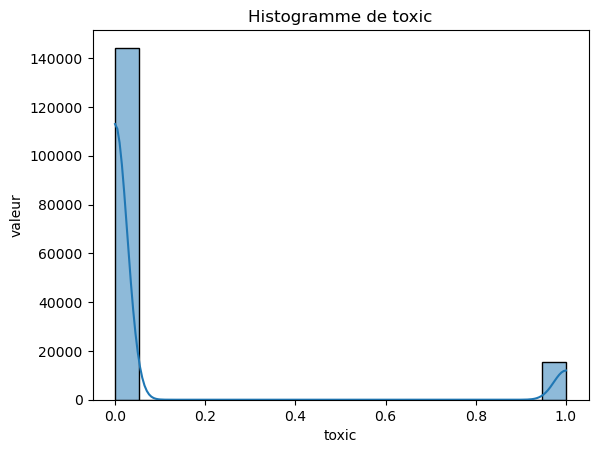

In [12]:
#analyse de la distribution des variables
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(toxic_train["toxic"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de toxic')
plt.xlabel("toxic")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

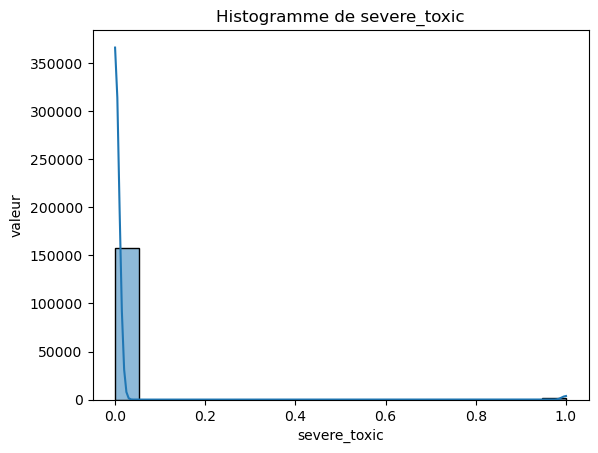

In [13]:
sns.histplot(toxic_train["severe_toxic"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de severe_toxic')
plt.xlabel("severe_toxic")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

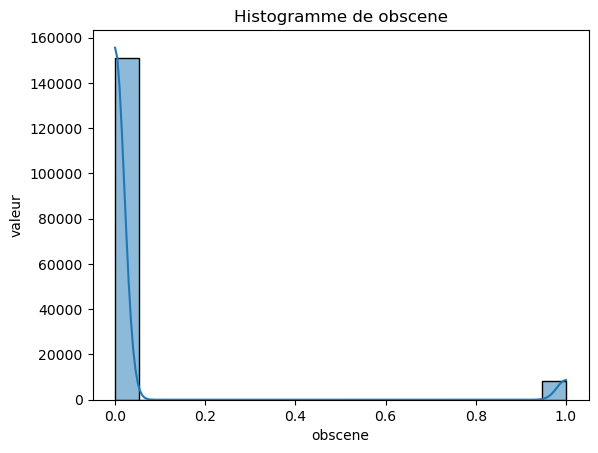

In [14]:
sns.histplot(toxic_train["obscene"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de obscene')
plt.xlabel("obscene")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

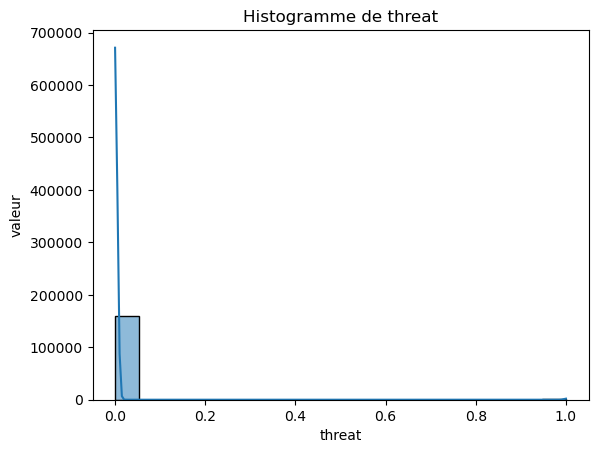

In [15]:
sns.histplot(toxic_train["threat"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de threat')
plt.xlabel("threat")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

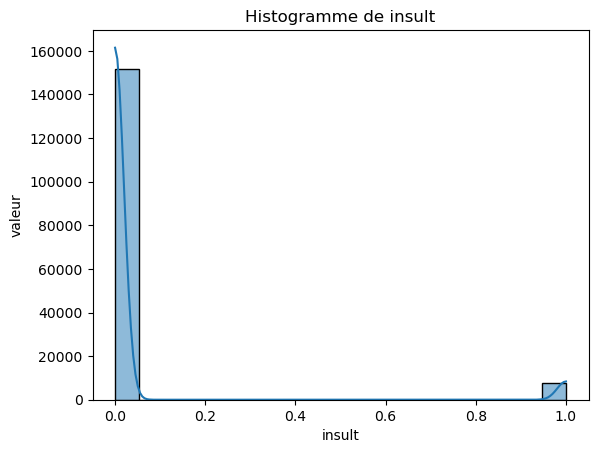

In [16]:
sns.histplot(toxic_train["insult"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de insult')
plt.xlabel("insult")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

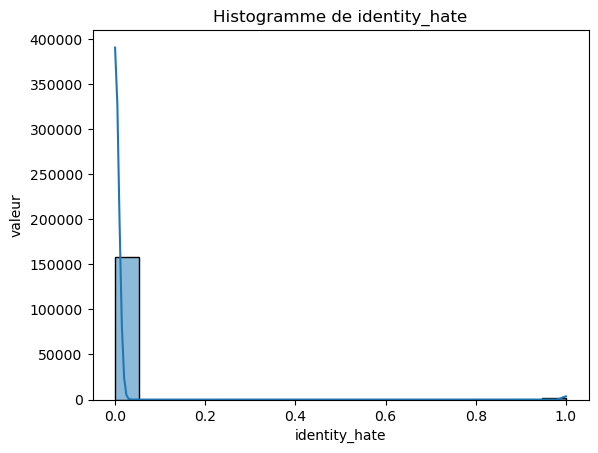

In [17]:
sns.histplot(toxic_train["identity_hate"], kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de identity_hate')
plt.xlabel("identity_hate")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

In [18]:
#très peu de positifs... il faudra s'attendre à un resampling

In [19]:
#je fais l'hypothèse que le jeu test présente les mêmes caractéritiques que le jeu train, la shape exceptée

In [20]:
# netoyage du jeu de donnée
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'http\S+', '', elem))
    df[text_field] = df[text_field].apply(lambda elem: elem.replace('\n', ' '))
    df[text_field] = df[text_field].apply(lambda elem: elem.replace('_', ' '))
    
    remove_digits = str.maketrans('', '', digits)
    df[text_field] = df[text_field].apply(lambda elem: elem.translate(remove_digits))
    return df

clean_toxic_train = clean_text(toxic_train, 'comment_text')
clean_toxic_test = clean_text(toxic_test, 'comment_text')

In [21]:
clean_toxic_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" more i can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [22]:
#la collone comment ext a changé. Les 

In [23]:
# Tokenization
#séparons les textes en sac de mots

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

#tokenizer
clean_toxic_train['tokens'] = clean_toxic_train['comment_text'].apply(tokenizer.tokenize)

clean_toxic_test['tokens'] = clean_toxic_test['comment_text'].apply(tokenizer.tokenize)

In [24]:
#vérifions
clean_toxic_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my..."
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,"[d, aww, he, matches, this, background, colour..."
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,"[hey, man, i, m, really, not, trying, to, edit..."
3,0001b41b1c6bb37e,""" more i can't make any real suggestions on im...",0,0,0,0,0,0,"[more, i, can, t, make, any, real, suggestions..."
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re..."


In [25]:
#la liste tokens a été créée, les mots ont bien été individualisés (safuf quelques uns comme daww)

In [26]:
# Explorer les mots et les phrases

all_words = [word for tokens in clean_toxic_train['tokens'] for word in tokens]

sentence_lengths = [len(tokens) for tokens in clean_toxic_train['tokens']]

Vocab = sorted(list(set(all_words)))

print('%s words total, with a vocabulary size of %s' %(len(all_words), len(Vocab)))

10792818 words total, with a vocabulary size of 167844


In [27]:
sentence_lengths

[46,
 16,
 44,
 116,
 14,
 10,
 8,
 21,
 86,
 12,
 501,
 12,
 54,
 147,
 40,
 107,
 11,
 6,
 21,
 84,
 40,
 11,
 80,
 11,
 232,
 22,
 52,
 58,
 28,
 13,
 18,
 13,
 10,
 139,
 56,
 146,
 199,
 51,
 28,
 213,
 37,
 39,
 116,
 8,
 59,
 142,
 14,
 20,
 121,
 200,
 478,
 26,
 33,
 96,
 9,
 19,
 13,
 118,
 339,
 70,
 18,
 55,
 5,
 165,
 33,
 56,
 23,
 30,
 39,
 37,
 32,
 62,
 11,
 189,
 37,
 11,
 44,
 51,
 28,
 13,
 184,
 494,
 96,
 52,
 17,
 23,
 14,
 9,
 61,
 4,
 152,
 72,
 17,
 17,
 90,
 96,
 10,
 23,
 33,
 54,
 17,
 4,
 19,
 76,
 17,
 8,
 154,
 108,
 28,
 23,
 15,
 8,
 109,
 78,
 249,
 11,
 97,
 9,
 48,
 7,
 42,
 52,
 45,
 27,
 20,
 25,
 997,
 33,
 40,
 80,
 44,
 29,
 52,
 37,
 119,
 33,
 18,
 46,
 8,
 9,
 159,
 64,
 334,
 60,
 21,
 119,
 8,
 37,
 88,
 75,
 123,
 102,
 10,
 80,
 18,
 39,
 24,
 53,
 43,
 19,
 587,
 44,
 426,
 18,
 28,
 26,
 120,
 155,
 28,
 68,
 64,
 11,
 79,
 6,
 33,
 6,
 30,
 1,
 19,
 135,
 229,
 11,
 7,
 40,
 23,
 28,
 23,
 18,
 29,
 40,
 51,
 67,
 47,
 16,
 10,
 48,
 

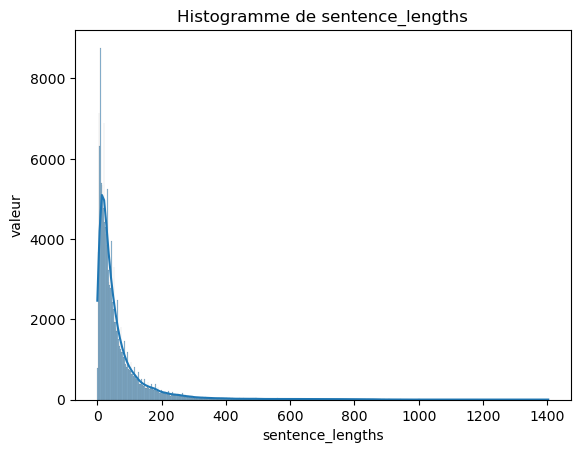

In [28]:
sns.histplot(sentence_lengths, kde=True)  # Utilisez kde=True pour ajouter une estimation de la densité
plt.title(f'Histogramme de sentence_lengths')
plt.xlabel("sentence_lengths")
plt.ylabel('valeur')
plt.show()  # Affichez l'histogramme

In [29]:
#la plupart des phrases sont très courtes...

In [30]:
from statistics import mean 

mean(sentence_lengths)

67.63646276579078

In [31]:
# Explorer vocab

print(Vocab[0:100])

from collections import Counter

count_all_words = Counter(all_words)
count_all_words.most_common(100)

['a', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany', 'aaaaaaaaaah', 'aaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaw', 'aaaaah', 'aaaah', 'aaaannnnyyyywwwwhhhheeeerrrreeee', 'aaaawwww', 'aaaboyz', 'aaages', 'aaaghh', 'aaah', 'aaahhh', 'aaahs', 'aaai', 'aaajade', 'aaan', 'aaand', 'aaarrrgggh', 'aaaww', 'aab', 'aaba', 'aaberg', 'aabove', 'aac', 'aacd', 'aachen', 'aachi', 'aacs', 'aad', 'aadd', 'aademia', 'aadil', 'aadmi', 'aadu', 'aaf', 'aaffect', 'aafia', 'aaflight', 'aafs', 'aagadu', 'aage', 'aagf', 'aagin', 'aah', 'aahahahahahaha', 'aahank', 'aahh', 'aahil', 'aahoa', 'aai', 'aaiha', 'aajacksoniv', 'aajonus', 'aakash', 'aake', 'aalborg', 'aalertbot', 'aalexa', 'aaliya', 'aaliyah', 'aals', 'aalst', 'aam', 'aami', 'aamir', 'aamirjamil', 'aaml', 'aamu', 'aan', 'aanas', 'aand', 'aandahl', 'aang', 'aao', 'aaot', 'aap', 'aapl', 'aapropriate', 'aar', 'aara

[('the', 496731),
 ('to', 297377),
 ('i', 240441),
 ('of', 224682),
 ('and', 224103),
 ('you', 218316),
 ('a', 216739),
 ('is', 176414),
 ('that', 160870),
 ('it', 148610),
 ('in', 145376),
 ('for', 102835),
 ('this', 97664),
 ('not', 93783),
 ('on', 89919),
 ('be', 83473),
 ('as', 77436),
 ('s', 73839),
 ('have', 72240),
 ('are', 72021),
 ('your', 63400),
 ('t', 61160),
 ('with', 59589),
 ('if', 58647),
 ('article', 57534),
 ('was', 54582),
 ('or', 53425),
 ('but', 51106),
 ('page', 46421),
 ('wikipedia', 46158),
 ('my', 45629),
 ('an', 44973),
 ('from', 41499),
 ('by', 41407),
 ('do', 40080),
 ('can', 39545),
 ('at', 39536),
 ('me', 37305),
 ('talk', 37255),
 ('about', 37132),
 ('so', 36605),
 ('what', 35630),
 ('there', 35278),
 ('all', 31646),
 ('has', 30727),
 ('will', 30470),
 ('please', 29799),
 ('no', 29331),
 ('would', 29322),
 ('they', 29317),
 ('he', 29194),
 ('one', 29183),
 ('like', 28005),
 ('just', 27826),
 ('we', 25430),
 ('which', 25368),
 ('any', 25148),
 ('been', 249

In [32]:
#les données sont exploitables, passons à la prédiction

In [33]:
#Classification par régréssion logistique.
#nous nous pencherons premièrement sur la prédiction de Toxic : ce sont les plus courants
#création du jeu train et test

from sklearn.model_selection import train_test_split

list_corpus = clean_toxic_train['comment_text']
list_labels = clean_toxic_train['toxic']
#, 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train, X_val, y_train, y_val = train_test_split(
    clean_toxic_train['comment_text'],
    clean_toxic_train['toxic'],
    test_size=0.2,
    random_state=0
)

In [34]:
#Embedding
# TFIDF bag of words

#TF-IDF est une méthode couramment utilisée pour transformer des documents textuels en vecteurs numériques,
# ce qui les rend adaptés à une utilisation dans des algorithmes de classification, d'apprentissage automatique, etc.

#import librairie
from sklearn.feature_extraction.text import TfidfVectorizer

# création du vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w+')

# apprentissage du vocabulaire uniquement sur X_train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# transformation de X_val avec le vocabulaire appris
X_val_tfidf = tfidf_vectorizer.transform(X_val)

#Affichage des dimensions des vecteurs TF-IDF :
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)



(127656, 147512)
(31915, 147512)


Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28814
           1       0.92      0.60      0.73      3101

    accuracy                           0.96     31915
   macro avg       0.94      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915

ROC AUC score: 0.973194318385888


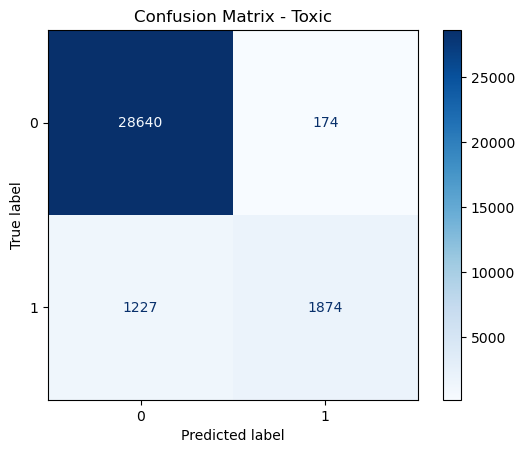

In [35]:
#classifier

#régréssion logisitique, non optimisée
#par contre, je vais augmenter le nbr d'itérations afin d'obtenir la convergence du modèle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

#Modélisation & entraînement

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_tfidf, y_train)


#Prédictions et évaluation

y_pred = classifier.predict(X_val_tfidf)
y_proba = classifier.predict_proba(X_val_tfidf)[:, 1]

print("Classification report:\n", classification_report(y_val, y_pred))
print("ROC AUC score:", roc_auc_score(y_val, y_proba))

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Toxic")
plt.show()

In [36]:
#résultats satisfaisants, penchons nous sur les autres catégories.


--- Résultats pour la classe : TOXIC ---
              precision    recall  f1-score   support

           0      0.961     0.994     0.977     28859
           1      0.912     0.617     0.736      3056

    accuracy                          0.958     31915
   macro avg      0.936     0.806     0.857     31915
weighted avg      0.956     0.958     0.954     31915



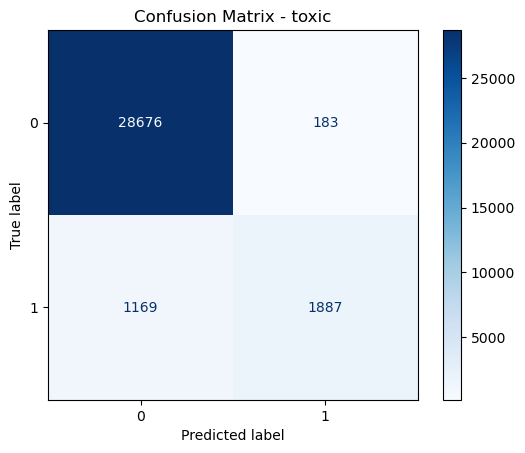


--- Résultats pour la classe : SEVERE_TOXIC ---
              precision    recall  f1-score   support

           0      0.993     0.998     0.995     31594
           1      0.585     0.259     0.359       321

    accuracy                          0.991     31915
   macro avg      0.789     0.628     0.677     31915
weighted avg      0.988     0.991     0.989     31915



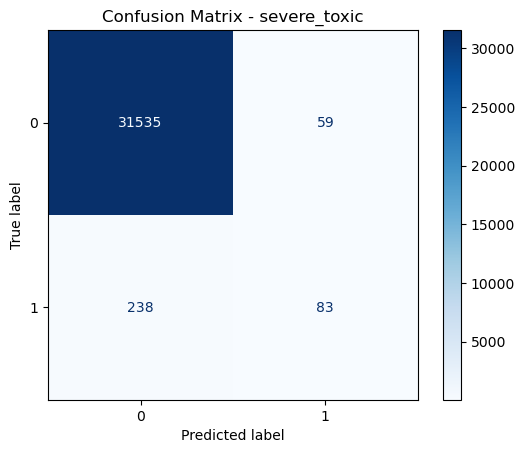


--- Résultats pour la classe : OBSCENE ---
              precision    recall  f1-score   support

           0      0.979     0.997     0.988     30200
           1      0.918     0.617     0.738      1715

    accuracy                          0.976     31915
   macro avg      0.948     0.807     0.863     31915
weighted avg      0.975     0.976     0.974     31915



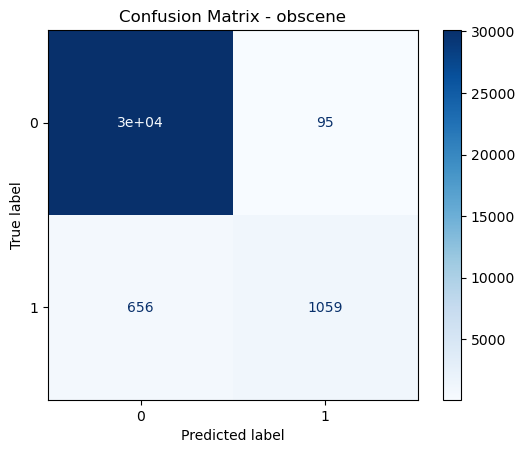


--- Résultats pour la classe : THREAT ---
              precision    recall  f1-score   support

           0      0.998     1.000     0.999     31841
           1      0.500     0.108     0.178        74

    accuracy                          0.998     31915
   macro avg      0.749     0.554     0.588     31915
weighted avg      0.997     0.998     0.997     31915



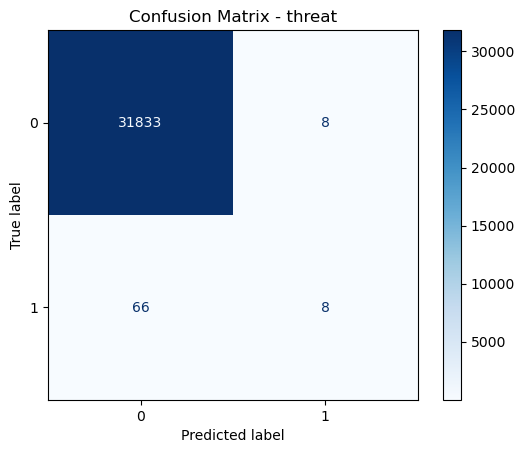


--- Résultats pour la classe : INSULT ---
              precision    recall  f1-score   support

           0      0.975     0.995     0.985     30301
           1      0.837     0.512     0.635      1614

    accuracy                          0.970     31915
   macro avg      0.906     0.753     0.810     31915
weighted avg      0.968     0.970     0.967     31915



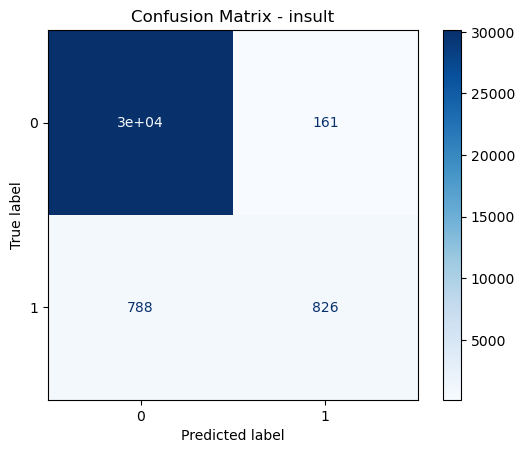


--- Résultats pour la classe : IDENTITY_HATE ---
              precision    recall  f1-score   support

           0      0.992     1.000     0.996     31621
           1      0.737     0.143     0.239       294

    accuracy                          0.992     31915
   macro avg      0.864     0.571     0.618     31915
weighted avg      0.990     0.992     0.989     31915



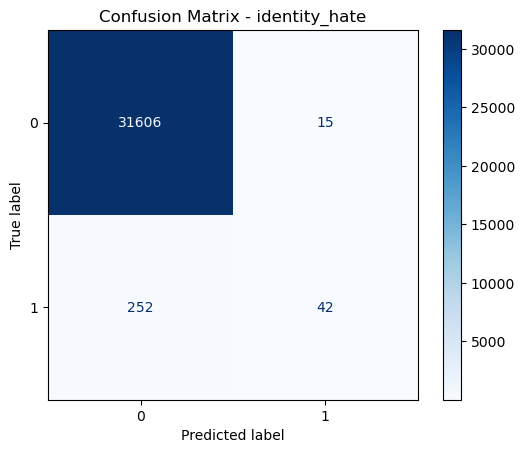

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Re-vectorisation sur X_train / X_val ===
X_train, X_val, y_train, y_val = train_test_split(
    clean_toxic_train['comment_text'],
    clean_toxic_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']],
    test_size=0.2,
    random_state=42
)

tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w+')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# === Modélisation ===
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in label_names:
    print(f"\n--- Résultats pour la classe : {label.upper()} ---")

    # 1. Extraction des cibles
    y_train_label = y_train[label]
    y_val_label = y_val[label]

    # 2. Modèle
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_tfidf, y_train_label)

    # 3. Prédiction
    y_pred = clf.predict(X_val_tfidf)

    # 4. Evaluation
    print(classification_report(y_val_label, y_pred, digits=3))

    # 5. Matrice de confusion
    cm = confusion_matrix(y_val_label, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {label}")
    plt.show()

In [38]:
toxic_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my..."


              precision    recall  f1-score   support

           0      0.980     0.966     0.973     28859
           1      0.717     0.818     0.765      3056

    accuracy                          0.952     31915
   macro avg      0.849     0.892     0.869     31915
weighted avg      0.955     0.952     0.953     31915



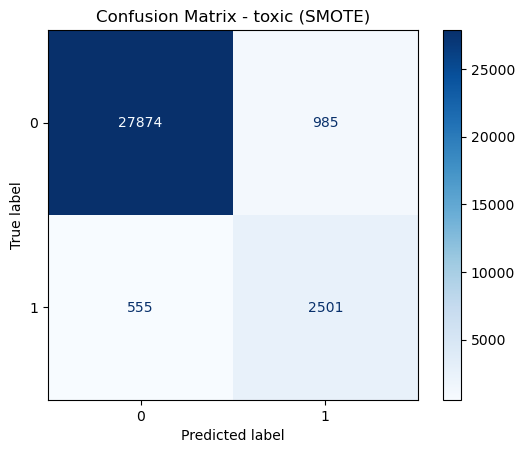

              precision    recall  f1-score   support

           0      0.998     0.982     0.990     31594
           1      0.312     0.791     0.448       321

    accuracy                          0.980     31915
   macro avg      0.655     0.887     0.719     31915
weighted avg      0.991     0.980     0.985     31915



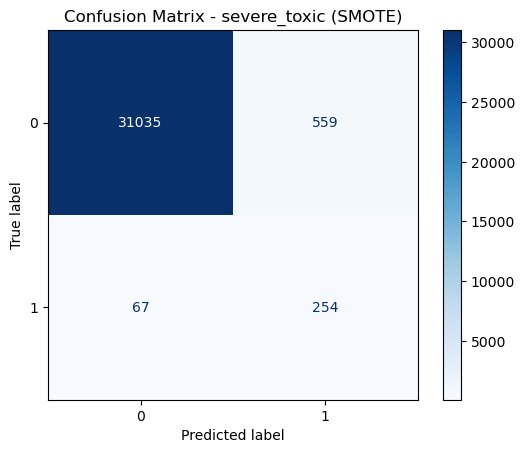

              precision    recall  f1-score   support

           0      0.991     0.985     0.988     30200
           1      0.765     0.843     0.802      1715

    accuracy                          0.978     31915
   macro avg      0.878     0.914     0.895     31915
weighted avg      0.979     0.978     0.978     31915



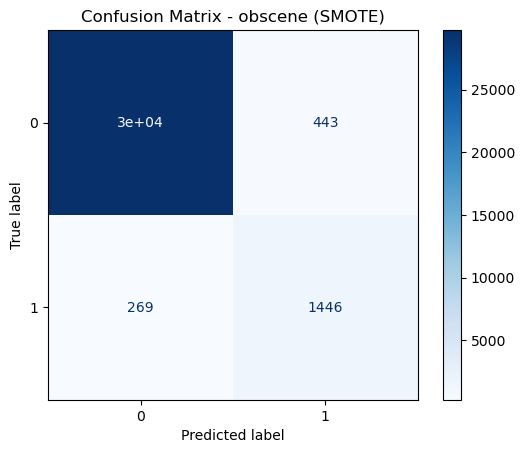

              precision    recall  f1-score   support

           0      0.999     0.995     0.997     31841
           1      0.244     0.703     0.362        74

    accuracy                          0.994     31915
   macro avg      0.622     0.849     0.680     31915
weighted avg      0.998     0.994     0.996     31915



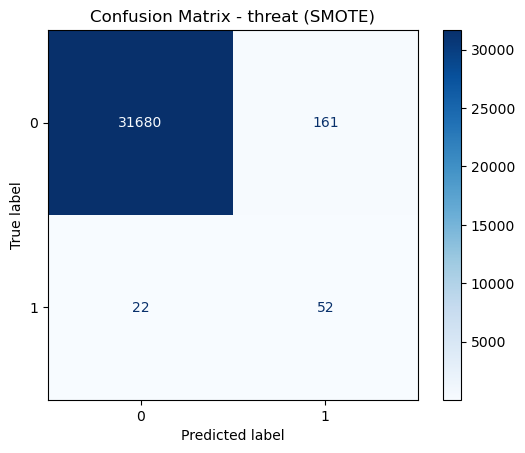

              precision    recall  f1-score   support

           0      0.990     0.975     0.982     30301
           1      0.633     0.817     0.713      1614

    accuracy                          0.967     31915
   macro avg      0.812     0.896     0.848     31915
weighted avg      0.972     0.967     0.969     31915



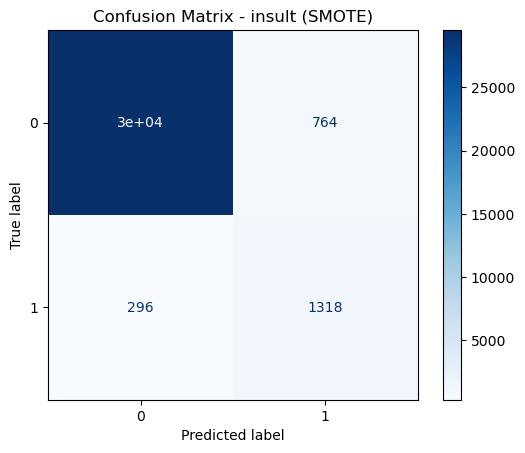

              precision    recall  f1-score   support

           0      0.997     0.985     0.991     31621
           1      0.300     0.701     0.420       294

    accuracy                          0.982     31915
   macro avg      0.649     0.843     0.706     31915
weighted avg      0.991     0.982     0.986     31915



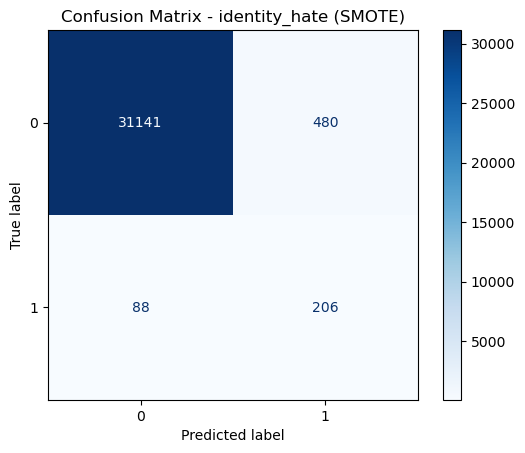

In [39]:
#notre jeu de données est déséquilibré. Un resampling pourrait permettre une amélioration des performances.

#Oversampling SMOTE.

from imblearn.over_sampling import SMOTE


#séparation jeux entrainement et test, entrainement, prédiction, métriques.
for label in label_names:
    #print(f"\n--- SMOTE + Régression logistique pour : {label.upper()} ---")
    
    # 1. Sur-échantillonnage
    X_res, y_res = SMOTE(random_state=42).fit_resample(X_train_tfidf, y_train[label])
    
    # 2. Modèle
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_res, y_res)
    
    # 3. Prédiction
    y_pred = clf.predict(X_val_tfidf)
    
    # 4. Évaluation
    print(classification_report(y_val[label], y_pred, digits=3))
    
    # 5. Matrice
    cm = confusion_matrix(y_val[label], y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {label} (SMOTE)")
    plt.show()

In [40]:
#l'oversampling SMOTE entraine une hausse du score F1 pour les catégories testées. Nous devons garder cette hypothèse de travail.

In [41]:
#je souhaite tester d'autres algorythmes : random forest, et XGboost. Nous conserverons le meilleur compris : performances, temps d'entrainement.


--- Résultats avec SMOTE pour : TOXIC ---
              precision    recall  f1-score   support

           0      0.980     0.966     0.973     28859
           1      0.717     0.818     0.765      3056

    accuracy                          0.952     31915
   macro avg      0.849     0.892     0.869     31915
weighted avg      0.955     0.952     0.953     31915



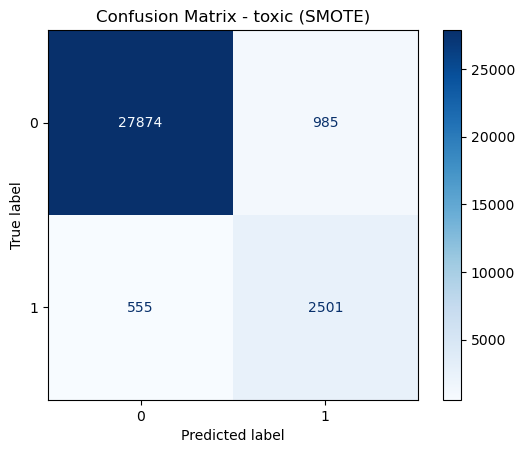

In [42]:
#en premier, SMOTE sur toxic uniquement

label = 'toxic'

# 1. SMOTE sur le label uniquement
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_tfidf, y_train[label])

# 2. Apprentissage
clf = LogisticRegression(max_iter=1000)
clf.fit(X_res, y_res)

# 3. Prédiction sur jeu de validation (non sur-échantillonné)
y_pred = clf.predict(X_val_tfidf)

# 4. Résultats
print(f"\n--- Résultats avec SMOTE pour : {label.upper()} ---")
print(classification_report(y_val[label], y_pred, digits=3))

cm = confusion_matrix(y_val[label], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - {label} (SMOTE)")
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28856
           1       0.86      0.52      0.65      3059

    accuracy                           0.95     31915
   macro avg       0.90      0.76      0.81     31915
weighted avg       0.94      0.95      0.94     31915



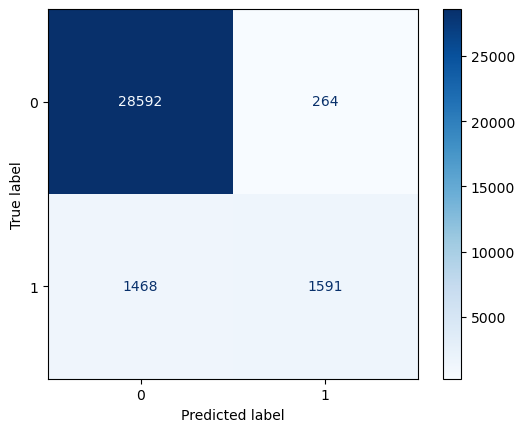

In [43]:
#random forest + SMOTE : entrainement avec paramètres fixes.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 1. Données pour le label 'toxic'
X = tfidf_vectorizer.transform(clean_toxic_train['comment_text'])
y = clean_toxic_train['toxic']

# 2. Découpage en train / val AVANT SMOTE pour éviter data leakage
X_train, X_val, y_train, y_val = train_test_split(    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# 4. Entraînement Random Forest (paramètres de base)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# 5. Prédiction
y_pred = rf.predict(X_val)

# 6. Évaluation
print(classification_report(y_val, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [44]:
#optionnel : tunning de la ramdom forest
"""
from sklearn.model_selection import GridSearchCV

# Param grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_res, y_train_res)
print("Meilleurs paramètres :", grid.best_params_)"""

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Param grid\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5]\n}\n\ngrid = GridSearchCV(\n    estimator=RandomForestClassifier(random_state=42),\n    param_grid=param_grid,\n    scoring=\'f1\',\n    cv=3,\n    n_jobs=-1,\n    verbose=2\n)\n\ngrid.fit(X_train_res, y_train_res)\nprint("Meilleurs paramètres :", grid.best_params_)'

In [45]:
#Analyse des performances

#Accuracy : 95 %, très bon score global, mais à prendre avec prudence dans un contexte de classes déséquilibrées.

#Classe 0 (non-toxique) :

#Precision = 0.95, Recall = 0.99 → Très bon classement, très peu de faux positifs.

#Classe 1 (toxique) :

#Precision = 0.85 → quand le modèle prédit “toxique”, c’est souvent correct.
#Recall = 0.52 → mais il rate près de 48 % des commentaires toxiques (faux négatifs).
#F1-score = 0.64 → équilibre modeste entre précision et recall.

# Conclusion : La Random Forest améliore la précision sur les classes minoritaires par rapport à la régression logistique sans SMOTE, mais le recall reste limité. Cela confirme que le modèle est prudent (préférence pour le négatif) mais perd des toxiques en route.

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     28856
           1       0.70      0.68      0.69      3059

    accuracy                           0.94     31915
   macro avg       0.83      0.83      0.83     31915
weighted avg       0.94      0.94      0.94     31915



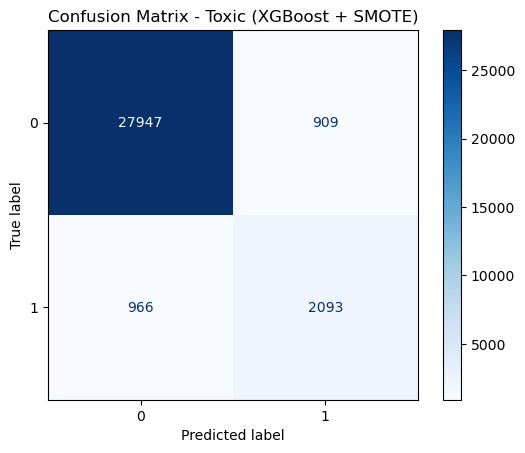

In [46]:
#XGBoost + SMOTE (sur une seule classe ici, toxic, et paramètres fixes) :

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# 1. Données pour le label 'toxic'
X = tfidf_vectorizer.transform(clean_toxic_train['comment_text'])
y = clean_toxic_train['toxic']

# 2. Découpage en train / val AVANT SMOTE pour éviter data leakage
X_train, X_val, y_train, y_val = train_test_split(    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


# 4. XGBoost Classifier
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train_res, y_train_res)

# 5. Prédiction
y_pred = xgb_model.predict(X_val)

# 6. Évaluation
print(classification_report(y_val, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Toxic (XGBoost + SMOTE)")
plt.show()

In [48]:
#optionnel : tunning de xgboost
"""
#paramètres e grille
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [1, float(sum(y==0))/sum(y==1)]  # gestion déséquilibre
}

#GridSearch
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_res, y_train_res)

print("Meilleurs paramètres :", grid.best_params_)
print("Score (CV) :", grid.best_score_)

# 5. Évaluation sur validation set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

print("\nRapport de classification :\n", classification_report(y_val, y_pred))

#Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()"""

'\n#paramètres e grille\nparam_grid = {\n    "n_estimators": [100, 300],\n    "max_depth": [3, 5, 7],\n    "learning_rate": [0.1, 0.05],\n    "subsample": [0.8, 1.0],\n    "colsample_bytree": [0.8, 1.0],\n    "scale_pos_weight": [1, float(sum(y==0))/sum(y==1)]  # gestion déséquilibre\n}\n\n#GridSearch\ngrid = GridSearchCV(\n    estimator=xgb_model,\n    param_grid=param_grid,\n    scoring="f1",\n    cv=3,\n    verbose=2,\n    n_jobs=-1\n)\n\ngrid.fit(X_train_res, y_train_res)\n\nprint("Meilleurs paramètres :", grid.best_params_)\nprint("Score (CV) :", grid.best_score_)\n\n# 5. Évaluation sur validation set\nbest_model = grid.best_estimator_\ny_pred = best_model.predict(X_val)\n\nprint("\nRapport de classification :\n", classification_report(y_val, y_pred))\n\n#Matrice de confusion\ncm = confusion_matrix(y_val, y_pred)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm)\ndisp.plot(cmap="Blues")\nplt.show()'

In [ ]:
#conclusion

#Régression logistique (baseline) :
#Déjà de bons résultats, surtout après SMOTE.
#Bon compromis simplicité/performance : hypothèse retenue.

#Réduction de dimensions (TruncatedSVD) :
#Pas concluant : perte de recall sur la classe minoritaire.

#Random Forest :
#Bonne précision, mais recall faible pour la classe toxique.

#XGBoost :
#Correct, mais pas meilleur que la régression logistique (surtout sans tuning).
#Plus coûteux en ressources.

